 # Extensions: Finite‐Pool Model Analysis



 We extend the infinite-pool cultural trait model to include a finite pool.

 Individuals innovate from a limited set of traits of size $K$.



 The system becomes non‐linear:

 $$

 f = P(f)^T f + b(f),

 $$

 requiring the nonlinear fixed‐point and Newton solvers.

 ## Setup

 Load libraries and helper functions.

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

from cultural_evolution.experiments import (
    generate_parameter_grid,
    run_experiments,
)
from cultural_evolution.solvers import solve_model
from cultural_evolution.analytical import popularity, persistence
from cultural_evolution.system import get_transition_matrix


 ## 1. Parameter Grid for Extensions

 Sweep over pool size $K$ in the finite‐pool model.

In [3]:
ext_params = {
    "N": [100],
    "M": [1, 3, 5],
    "p_d": [0.1],
    "p_s": [0.4],
    "pool": ["finite"],
    "K": [50, 100, 200],
    "attempt": ["union"],
    "sampling": ["with"],
}
grid_ext = generate_parameter_grid(ext_params)
solver_configs_ext = [
    {"mode": "popularity", "solver": "nonlinear", "trace": True},
    {"mode": "popularity", "solver": "newton", "trace": True},
]

# Run experiments
ext_summary, ext_solutions = run_experiments(
    grid_ext, solver_configs_ext, parallel=True, show_progress=True
)

# Display summary
ext_summary.head()



Running experiments: 100%|██████████| 18/18 [01:44<00:00,  5.79s/it]


,N,M,p_d,p_s,pool,K,attempt,sampling,mode,solver,time,iterations,error_L2,error_inf
0,100,1,0.1,0.4,finite,200,union,with,popularity,newton,2.114955,2,0.613368,0.600458
1,100,3,0.1,0.4,finite,50,union,with,popularity,newton,2.172577,2,14.157941,6.784144
2,100,1,0.1,0.4,finite,100,union,with,popularity,newton,2.253827,2,1.157248,1.132891
3,100,1,0.1,0.4,finite,50,union,with,popularity,newton,3.293040,3,2.078971,2.035214
4,100,3,0.1,0.4,finite,100,union,with,popularity,newton,3.320270,3,10.712844,5.133337


 ### Popularity Distributions by Pool Size

 Compare analytical vs solver distributions for different $K$ at fixed parameters.

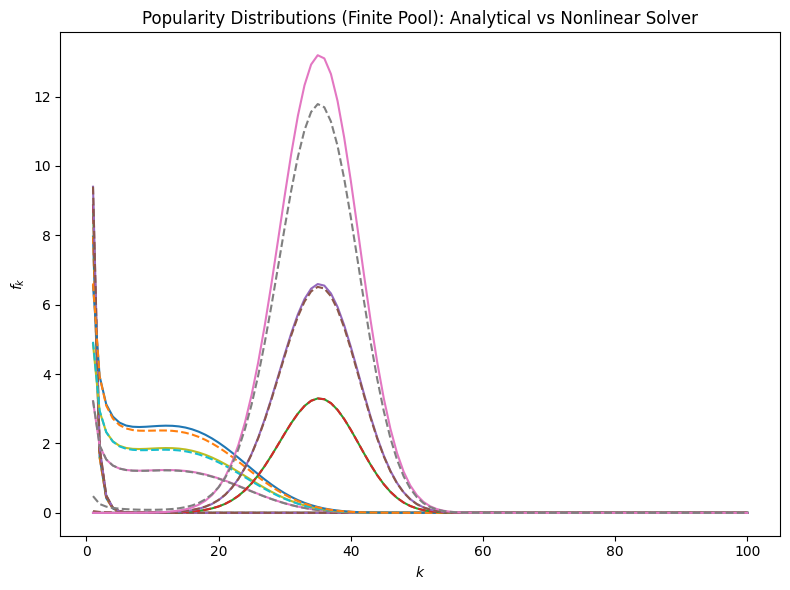

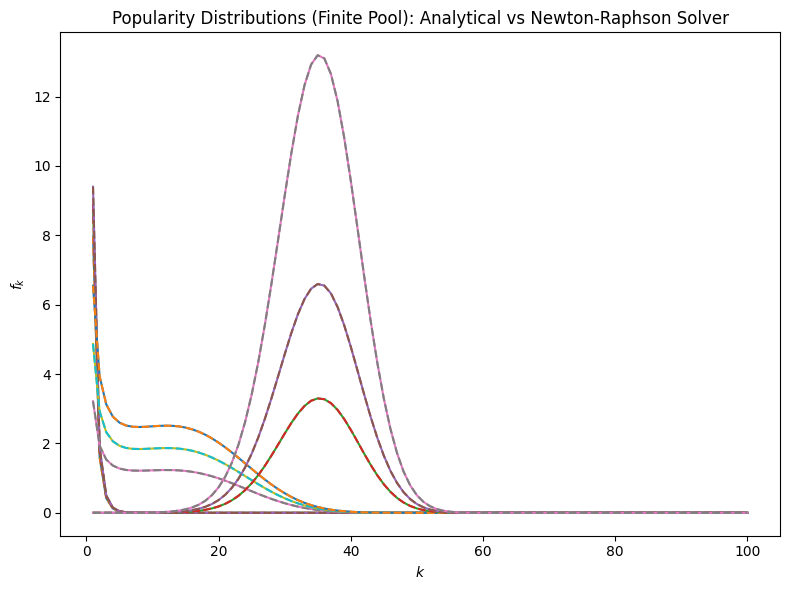

In [14]:
plt.figure(figsize=(8, 6))
k = np.arange(1, ext_params["N"][0] + 1)
for M_val in ext_params["M"]:
    for K_val in ext_params["K"]:
        params = {
            "N": ext_params["N"][0],
            "M": M_val,
            "p_d": ext_params["p_d"][0],
            "p_s": ext_params["p_s"][0],
            "pool": "finite",
            "K": K_val,
            "attempt": "union",
            "sampling": "with",
        }
        # analytical
        f_true = popularity(**params)
        plt.plot(k, f_true)
        # solver
        sol_vec = ext_solutions[
            (ext_solutions["solver"] == "nonlinear")
            & (ext_solutions["mode"] == "popularity")
            & (ext_solutions["M"] == M_val)
            & (ext_solutions["K"] == K_val)
        ]["solution"].values[0]
        plt.plot(k, sol_vec, "--")
plt.xlabel(r"$k$")
plt.ylabel(r"$f_k$")
plt.title("Popularity Distributions (Finite Pool): Analytical vs Nonlinear Solver")
plt.tight_layout()


plt.figure(figsize=(8, 6))
k = np.arange(1, ext_params["N"][0] + 1)
for M_val in ext_params["M"]:
    for K_val in ext_params["K"]:
        params = {
            "N": ext_params["N"][0],
            "M": M_val,
            "p_d": ext_params["p_d"][0],
            "p_s": ext_params["p_s"][0],
            "pool": "finite",
            "K": K_val,
            "attempt": "union",
            "sampling": "with",
        }
        # analytical
        f_true = popularity(**params)
        plt.plot(k, f_true)
        # solver
        sol_vec = ext_solutions[
            (ext_solutions["solver"] == "newton")
            & (ext_solutions["mode"] == "popularity")
            & (ext_solutions["M"] == M_val)
            & (ext_solutions["K"] == K_val)
        ]["solution"].values[0]
        plt.plot(k, sol_vec, "--")
plt.xlabel(r"$k$")
plt.ylabel(r"$f_k$")
plt.title("Popularity Distributions (Finite Pool): Analytical vs Newton-Raphson Solver")
plt.tight_layout()


 ### Total Traits & Diversity vs Pool Size

 Plot total traits as functions of $K$.

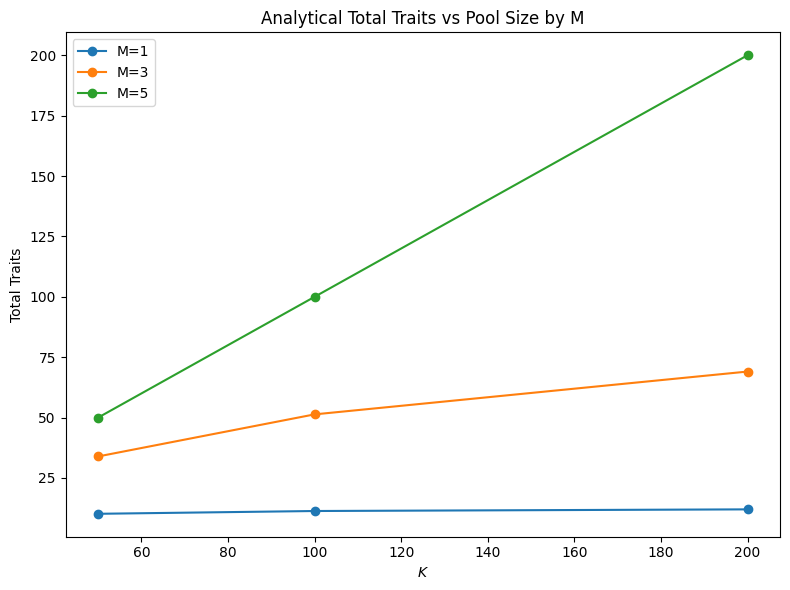

In [5]:
records = []
for M_val in ext_params["M"]:
    for K_val in ext_params["K"]:
        params = {
            "N": ext_params["N"][0],
            "M": M_val,
            "p_d": ext_params["p_d"][0],
            "p_s": ext_params["p_s"][0],
            "pool": "finite",
            "K": K_val,
            "attempt": "union",
            "sampling": "with",
        }
        f = popularity(**params)
        total = np.sum(f)
        records.append({"M": M_val, "K": K_val, "total_traits": total})
df_div = pd.DataFrame(records)

# Plot total traits vs K for each M
plt.figure(figsize=(8, 6))
for M_val in ext_params["M"]:
    sub = df_div[df_div["M"] == M_val]
    plt.plot(sub["K"], sub["total_traits"], marker="o", label=f"M={M_val}")
plt.xlabel(r"$K$")
plt.ylabel("Total Traits")
plt.title("Analytical Total Traits vs Pool Size by M")
plt.legend()
plt.tight_layout()


 ## 2. Solver Performance

 ### Solver Summary Metrics (Finite Pool)

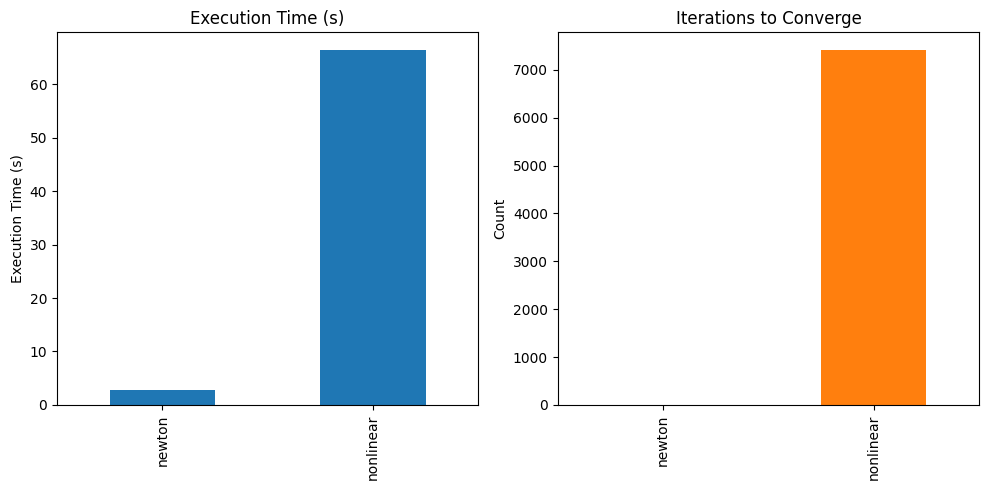

In [18]:
# Average metrics across parameters per solver
summary_ext = ext_summary.groupby("solver")[["time",  "iterations"]].mean()

# Plot bar charts for each metric
axes = summary_ext.plot(
    kind="bar", subplots=True, layout=(1, 3), figsize=(15, 5), legend=False, sharex=True
)

# Label each subplot
metrics = ["time", "iterations"]
titles = ["Execution Time (s)", "Iterations to Converge"]
for ax, title in zip(axes.flatten(), titles):
    ax.set_title(title)
    ax.set_xlabel("")  # remove x‐axis label on subplots
    ax.set_ylabel(title if title != "Iterations to Converge" else "Count")

plt.tight_layout()


 ## Convergence Profiles: Iterations vs Tolerance (Finite Pool)

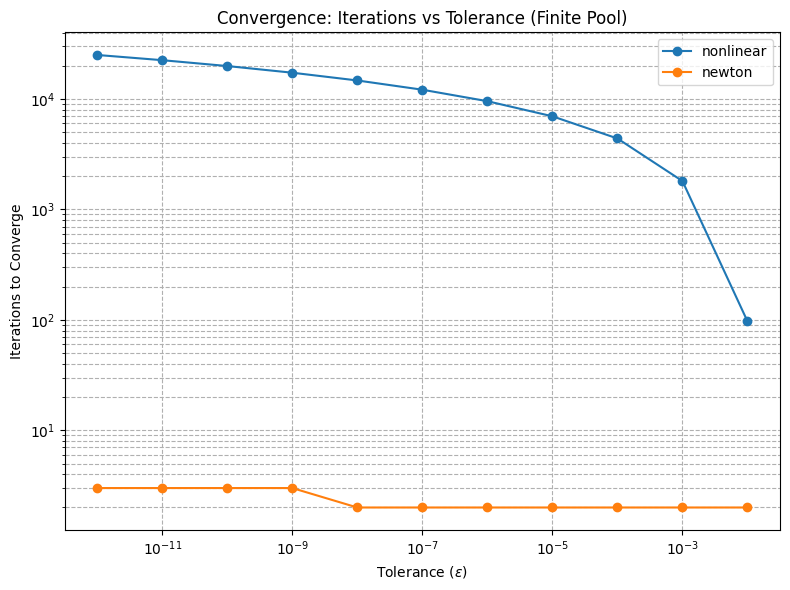

In [10]:
tol_values = np.logspace(-2, -12, 11)
solvers = ["nonlinear", "newton"]
results_conv = {solver: [] for solver in solvers}

# Representative parameter set for convergence sweep
single_ext = {
    "N": ext_params["N"][0],
    "M": ext_params["M"][2],
    "p_d": ext_params["p_d"][0],
    "p_s": ext_params["p_s"][0],
    "pool": "finite",
    "K": ext_params["K"][0],
    "attempt": "union",
    "sampling": "with",
}

for tol in tol_values:
    for solver in solvers:
        _, residuals = solve_model(
            **single_ext, mode="popularity", solver=solver, tol=tol, trace=True, max_iter=0
        )
        results_conv[solver].append(len(residuals))

plt.figure(figsize=(8, 6))
for solver in solvers:
    plt.loglog(tol_values, results_conv[solver], marker="o", label=solver)
plt.xlabel(r"Tolerance ($\epsilon$)")
plt.ylabel("Iterations to Converge")
plt.title("Convergence: Iterations vs Tolerance (Finite Pool)")
plt.legend()
plt.grid(True, which="both", linestyle="--")
plt.tight_layout()


 ## Residual Decay for Solvers (Finite Pool)

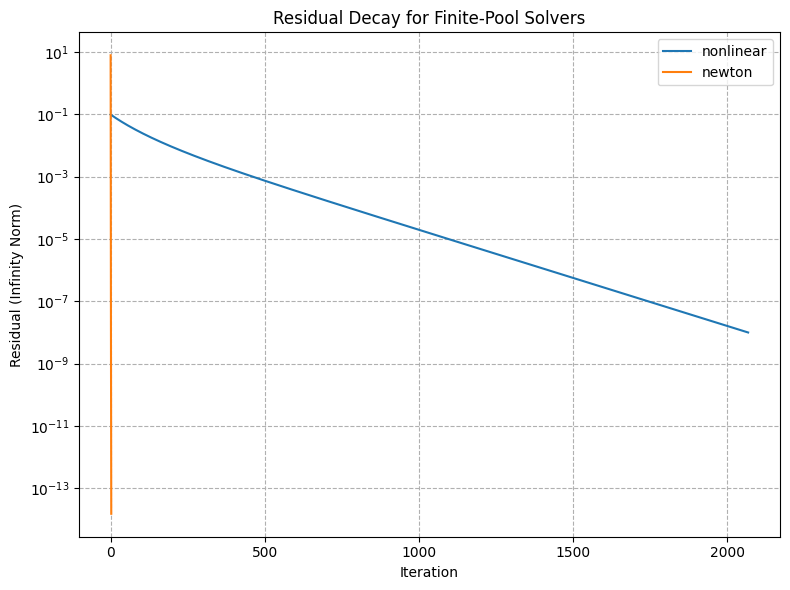

In [8]:
plt.figure(figsize=(8, 6))
solvers = ["nonlinear", "newton"]
# Representative parameter set for residuals
single_ext = {
    "N": ext_params["N"][0],
    "M": ext_params["M"][0],
    "p_d": ext_params["p_d"][0],
    "p_s": ext_params["p_s"][0],
    "pool": "finite",
    "K": ext_params["K"][0],
    "attempt": "union",
    "sampling": "with",
}

for solver in solvers:
    _, residuals = solve_model(
        **single_ext, mode="popularity", solver=solver, tol=1e-8, trace=True
    )
    plt.semilogy(residuals, label=solver)

plt.xlabel("Iteration")
plt.ylabel("Residual (Infinity Norm)")
plt.title("Residual Decay for Finite‐Pool Solvers")
plt.legend()
plt.grid(True, which="both", linestyle="--")
plt.tight_layout()


 ## Solver Metrics Heatmaps over (M, K) for Finite Pool

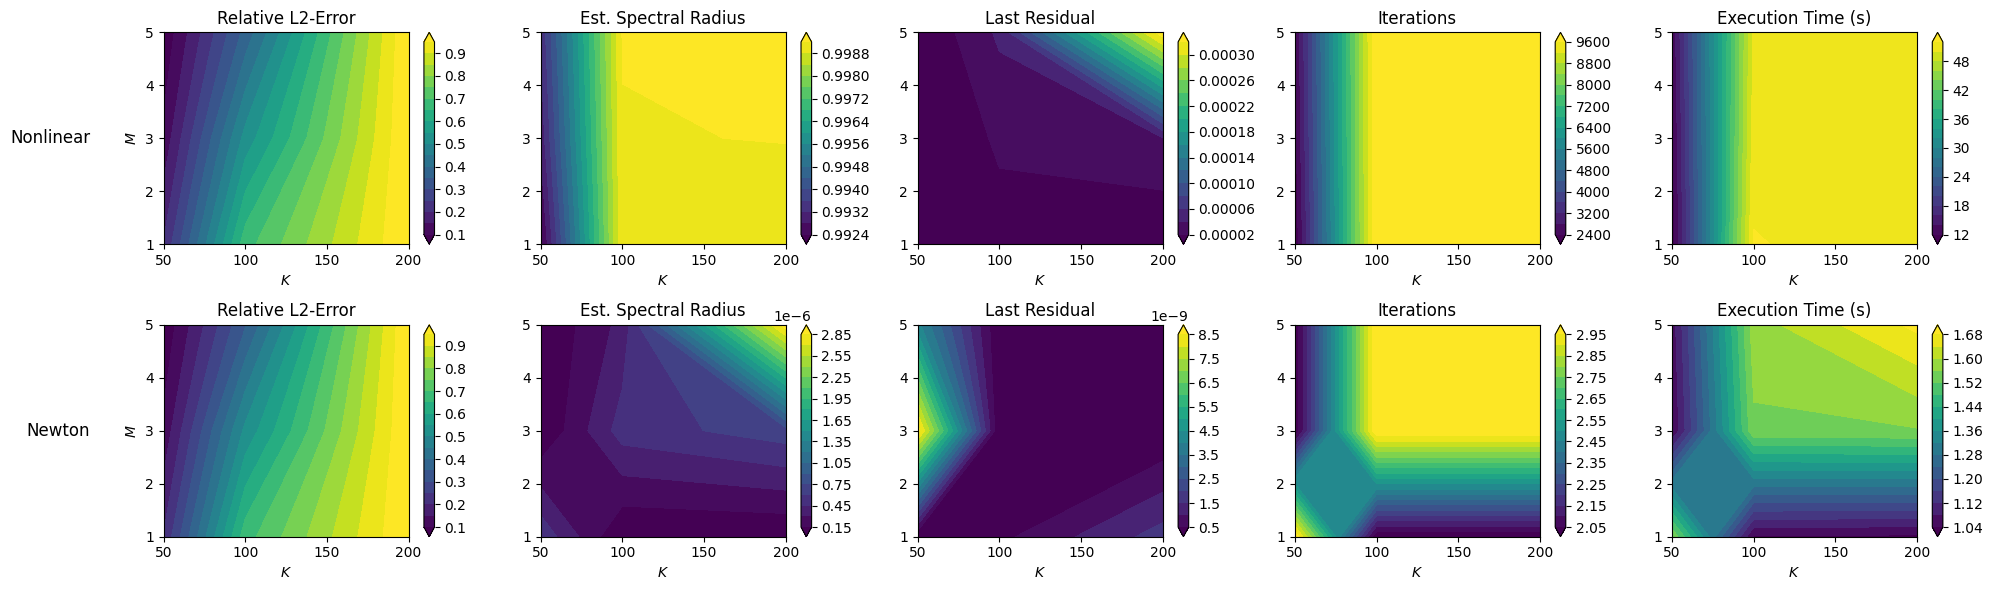

In [9]:
solvers = ["nonlinear", "newton"]
metrics = ["rel_error", "spec_rad", "last_residual", "iterations", "time"]

# Parameter grids
Ms = ext_params["M"]
Ks = ext_params["K"]
N_val = ext_params["N"][0]
p_d_val = ext_params["p_d"][0]
p_s_val = ext_params["p_s"][0]

# Initialize storage
data = {
    solver: {m: np.zeros((len(Ms), len(Ks))) for m in metrics} for solver in solvers
}

# Sweep over M, K
for i, M_val in enumerate(Ms):
    for j, K_val in enumerate(Ks):
        # Build the finite‐pool transition matrix (not strictly needed for rel_error)
        P, b = get_transition_matrix(
            N_val,
            M_val,
            p_d_val,
            p_s_val,
            attempt="union",
            sampling="with",
            pool="finite",
            K=K_val,
            L=None,
            f=None,
        )
        # Analytical infinite‐pool baseline
        f_true = popularity(N=N_val, M=M_val, p_d=p_d_val, p_s=p_s_val)

        for solver in solvers:
            # Time the solver
            t0 = time.time()
            sol, residuals = solve_model(
                N=N_val,
                M=M_val,
                p_d=p_d_val,
                p_s=p_s_val,
                pool="finite",
                K=K_val,
                attempt="union",
                sampling="with",
                mode="popularity",
                solver=solver,
                trace=True,
            )
            data[solver]["time"][i, j] = time.time() - t0

            # Relative L2‐error against infinite‐pool analytical
            data[solver]["rel_error"][i, j] = np.linalg.norm(
                sol - f_true
            ) / np.linalg.norm(f_true)

            # Iterations and last residual
            data[solver]["iterations"][i, j] = len(residuals)
            data[solver]["last_residual"][i, j] = residuals[-1] if residuals else np.nan

            # Estimated spectral radius from residual ratios
            if len(residuals) > 1:
                ratios = np.array(residuals[1:]) / np.array(residuals[:-1])
                data[solver]["spec_rad"][i, j] = np.mean(ratios)
            else:
                data[solver]["spec_rad"][i, j] = np.nan

# Plot solver heatmaps
fig, axes = plt.subplots(
    len(solvers), len(metrics), figsize=(4 * len(metrics), 3 * len(solvers))
)
for si, solver in enumerate(solvers):
    for mi, metric in enumerate(metrics):
        ax = axes[si, mi]
        X, Y = np.meshgrid(Ks, Ms)  # note: x-axis=K, y-axis=M
        Z = data[solver][metric].T  # transpose so that shape matches (len(Ms),len(Ks))
        cf = ax.contourf(X, Y, Z, levels=20, cmap="viridis", extend="both")
        ax.set_xlabel(r"$K$")
        if mi == 0:
            ax.set_ylabel(r"$M$")
        # prettier titles
        titles = {
            "rel_error": "Relative L2-Error",
            "spec_rad": "Est. Spectral Radius",
            "last_residual": "Last Residual",
            "iterations": "Iterations",
            "time": "Execution Time (s)",
        }
        ax.set_title(titles[metric])
        fig.colorbar(cf, ax=ax)

    # label each row by solver
    axes[si, 0].text(
        -0.3,
        0.5,
        solver.title(),
        va="center",
        ha="right",
        transform=axes[si, 0].transAxes,
        fontsize=12,
    )

fig.tight_layout()
